# Deep Learning Project | ResNet50

In [1]:
# TensorFlow and Keras for model building
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

# Other utilities
import os
import numpy as np
import matplotlib.pyplot as plt

Constants

In [13]:
# IMAGE_SIZE = 299
IMAGE_SIZE = 224
BATCH_SIZE = 32 # Lowered batch size to reduce memory consumption
CLASSES = 3
EPOCHS = 60

# Dataset directory declaration

📥 Dataset Source:

✅ Option 1: Download dataset manually from Kaggle
Example: https://www.kaggle.com/datasets (Choose your dataset)
After downloading, extract it to your working directory, e.g., './dataset_folder'

✅ Option 2 (Optional Advanced): Use Kaggle API to download directly
`!kaggle datasets download -d username/dataset-name`
`!unzip dataset-name.zip -d ./dataset_folder`

In [ ]:
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory("fruits-360",
shuffle=True,
image_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE
)

#Calls and Displays class names from dataset
class_names = dataset.class_names
class_names

Found 1440 files belonging to 3 classes.


['Mango-Green', 'Mango-Red', 'Mango-Yellow']

# Plots images from their respective classes

This Assumes 'dataset' is a tf.data.Dataset object and 'class_names' contains your dataset's class labels

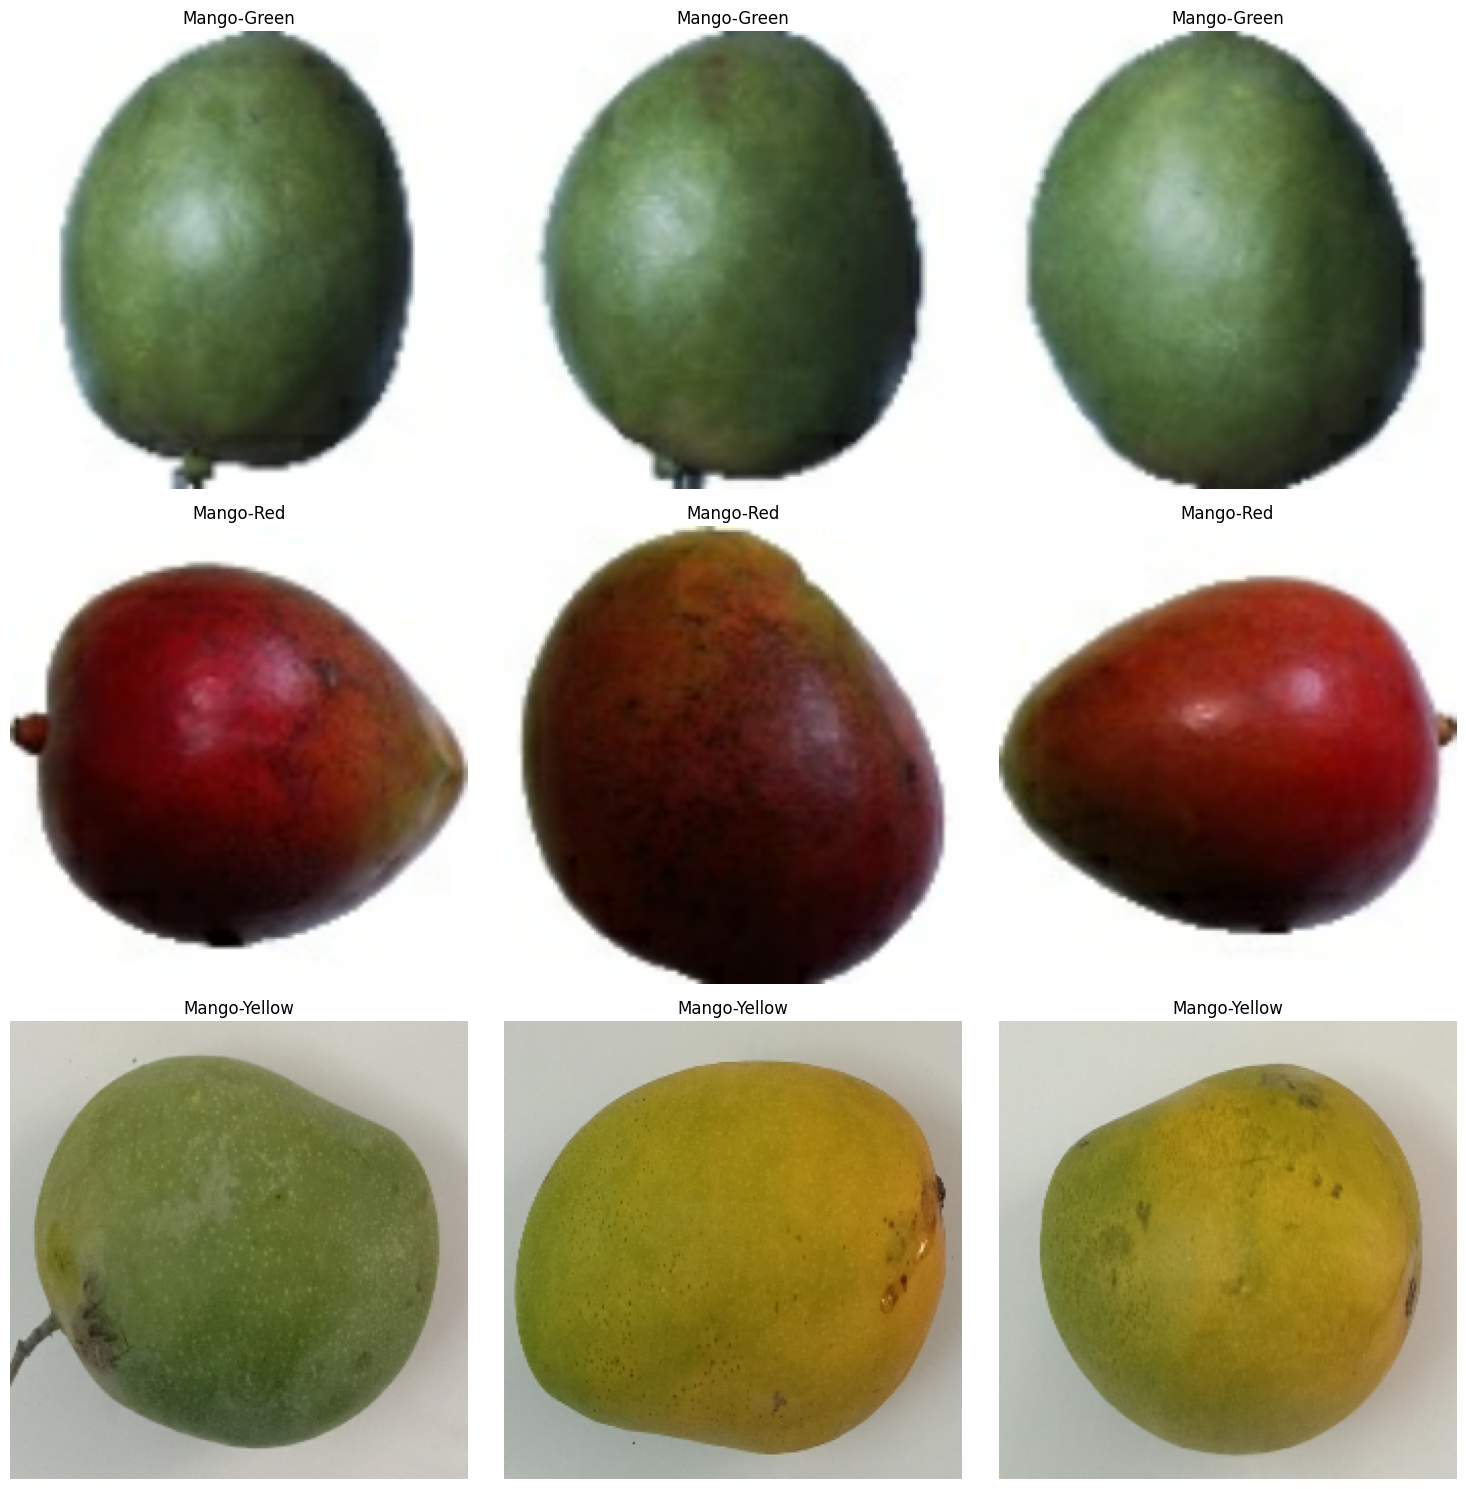

In [ ]:
import matplotlib.pyplot as plt


# Varies: Update this list based on YOUR dataset class names
class_names_of_interest = ['Mango-Green','Mango-Red','Mango-Yellow']

# Ensure these class names match EXACTLY with what's inside dataset.class_names
class_indices = [class_names.index(name) for name in class_names_of_interest]  # Get class indices

# Initialize a dictionary to store a few images per class
healthy_images = {name: [] for name in class_names_of_interest}

# Collect 3 sample images per selected class (Can change number if you want more/less images)
for images, labels in dataset:
    for i in range(len(labels)):
        label = labels[i].numpy()
        
        # Critical: Ensure your label mapping logic works (Some datasets may return one-hot encoded labels)
        if label in class_indices and len(healthy_images[class_names[label]]) < 3:
            healthy_images[class_names[label]].append((images[i], labels[i]))
            
        # Varies: Stop when 3 samples for each class are collected (Change 3 if you want more/less)
        if all(len(healthy_images[name]) == 3 for name in class_names_of_interest):
            break
    if all(len(healthy_images[name]) == 3 for name in class_names_of_interest):
        break

# Plot the images
plt.figure(figsize=(15, 15))  # 🔄 Varies: Adjust figure size based on number of classes or samples per class
for i, name in enumerate(class_names_of_interest):
    for j, (image, label) in enumerate(healthy_images[name]):
        ax = plt.subplot(len(class_names_of_interest), 3, i * 3 + j + 1)  # Varies: '3' is samples per class
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(name)
        plt.axis("off")

plt.tight_layout()
plt.show()


# Splitting Dataset to 80-10-10, training, validation and test respectively
### Apply Augmentation
You can change the datasplit according to how much you need

CHANGE VALUES OF `train_split`, `val_split`, `test_split` from the `get_dataset_partitions_tf()` method according to your Splitting Ratio

In [16]:
import tensorflow as tf
from tensorflow import keras

# Define image size for cropping
IMAGE_SIZE = 224  # Adjust as needed

# Create augmentation layers once (tf.Variables are created only once here)
crop_layer = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)
rotate_layer = keras.layers.RandomRotation(0.1)      # Example rotation augmentation
contrast_layer = keras.layers.RandomContrast(0.1)      # Example contrast augmentation

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, 
                              shuffle=True, shuffle_size=1000, augment_data=True):
    # Example implementation for splitting your dataset
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    # Optionally shuffle the dataset
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    if augment_data:
        # Apply augmentation to the training set using the pre-created layers
        cropped_train_ds = train_ds.map(lambda x, y: (crop_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        rotated_train_ds = train_ds.map(lambda x, y: (rotate_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        contrasted_train_ds = train_ds.map(lambda x, y: (contrast_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
        # Choose one augmented version or combine them as needed
        # Here we use cropped_train_ds as an example
        train_ds = cropped_train_ds
    
    return train_ds, val_ds, test_ds

# Assuming 'dataset' is already loaded:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


# Shuffling and Cache the dataset for faster model training

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Load ResNet50 Model

In [20]:
resnet_model = keras.Sequential()

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg', classes=3)


# REPLACE '4' from dense layer accoringly to how much classifiers you have in your dataset
predictions = Dense(4, activation='softmax')

for layer in base_model.layers:
    layer.trainable = False

# Add or remove layers to your liking
# You can achieve high results via experimental process

resnet_model.add(base_model) # DO NOT REMOVE THIS, this is the layer for your actual model
resnet_model.add(layers.Flatten())

# Regularization and Dropout
resnet_model.add(layers.Dense(64, activation='relu', kernel_regularizer=L2(0.005)))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dropout(0.5))

resnet_model.add(layers.Dense(32, activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dropout(0.1))

resnet_model.add(predictions) # DO NOT REMOVE THIS, this layer is responsible for you predictions

resnet_model.summary() # This simply summarizes and shows the entire layers of your model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                131136    
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                      

# Dataset directory declaration

📥 Dataset Source:

✅ Option 1: Download dataset manually from Kaggle
Example: https://www.kaggle.com/datasets (Choose your dataset)
After downloading, extract it to your working directory, e.g., './dataset_folder'

✅ Option 2 (Optional Advanced): Use Kaggle API to download directly
`!kaggle datasets download -d username/dataset-name`
`!unzip dataset-name.zip -d ./dataset_folder`

In [21]:
# Compile the model with an Adam optimizer and categorical crossentropy loss
resnet_model.compile(optimizer=Adam(learning_rate=0.001, decay=0.01,), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'], run_eagerly=True)

# Time to train with Model.fit() 

In [22]:
import tensorflow as tf

TOTAL_GPU_MEMORY_MB = 8192  # Adjust this to your GPU's total memory
memory_limit = int(0.98 * TOTAL_GPU_MEMORY_MB)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Set GPU memory limit to {memory_limit} MB on {len(logical_gpus)} logical GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found.")
    
tf.config.set_soft_device_placement(True)
print("Soft device placement enabled.")

Virtual devices cannot be modified after being initialized
Soft device placement enabled.


In [ ]:
for images, labels in train_ds.take(1):
    print(images.shape)  # Should print (batch_size, 32, 224, 224, 3)

(32, 224, 224, 3)


In [24]:
# Train the model on the dataset
history = resnet_model.fit(
    train_ds,
    epochs=30,  # You can adjust epochs based on your dataset
    validation_data=val_ds,
)


Epoch 1/30
36/36 [==============================] - 11s 233ms/step - loss: 0.8940 - accuracy: 0.9175 - val_loss: 0.5232 - val_accuracy: 1.0000
Epoch 2/30
36/36 [==============================] - 8s 221ms/step - loss: 0.5154 - accuracy: 0.9974 - val_loss: 0.4028 - val_accuracy: 1.0000
Epoch 3/30
36/36 [==============================] - 8s 221ms/step - loss: 0.4130 - accuracy: 0.9991 - val_loss: 0.3424 - val_accuracy: 1.0000
Epoch 4/30
36/36 [==============================] - 8s 224ms/step - loss: 0.3541 - accuracy: 0.9991 - val_loss: 0.3013 - val_accuracy: 1.0000
Epoch 5/30
36/36 [==============================] - 10s 271ms/step - loss: 0.3097 - accuracy: 0.9991 - val_loss: 0.2698 - val_accuracy: 1.0000
Epoch 6/30
36/36 [==============================] - 11s 299ms/step - loss: 0.2790 - accuracy: 1.0000 - val_loss: 0.2448 - val_accuracy: 1.0000
Epoch 7/30
36/36 [==============================] - 10s 288ms/step - loss: 0.2543 - accuracy: 0.9991 - val_loss: 0.2258 - val_accuracy: 1.0000
Ep

# Dataset directory declaration

📥 Dataset Source:

✅ Option 1: Download dataset manually from Kaggle
Example: https://www.kaggle.com/datasets (Choose your dataset)
After downloading, extract it to your working directory, e.g., './dataset_folder'

✅ Option 2 (Optional Advanced): Use Kaggle API to download directly
`!kaggle datasets download -d username/dataset-name`
`!unzip dataset-name.zip -d ./dataset_folder`

# Dataset directory declaration

📥 Dataset Source:

✅ Option 1: Download dataset manually from Kaggle
Example: https://www.kaggle.com/datasets (Choose your dataset)
After downloading, extract it to your working directory, e.g., './dataset_folder'

✅ Option 2 (Optional Advanced): Use Kaggle API to download directly
`!kaggle datasets download -d username/dataset-name`
`!unzip dataset-name.zip -d ./dataset_folder`

### The recent model performance is declared on the `history` variable, so all of our metrics can be accessed through the `history` variable

In [25]:
#show highest accuracy and validation accuracy show lowest loss and validation loss and latest of each
print("Highest Accuracy: ", max(history.history['accuracy']))
print("Highest Validation Accuracy: ", max(history.history['val_accuracy']))
print("Lowest Loss: ", min(history.history['loss']))
print("Lowest Validation Loss: ", min(history.history['val_loss']))
print("Final Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Loss: ", history.history['loss'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])

Highest Accuracy:  1.0
Highest Validation Accuracy:  1.0
Lowest Loss:  0.09211495518684387
Lowest Validation Loss:  0.08490344136953354
Final Accuracy:  1.0
Final Validation Accuracy:  1.0
Final Loss:  0.09211495518684387
Final Validation Loss:  0.08490344136953354


# Making a Prediction (Not Fine Tuned)

1/1 [==============================] - 0s 74ms/step


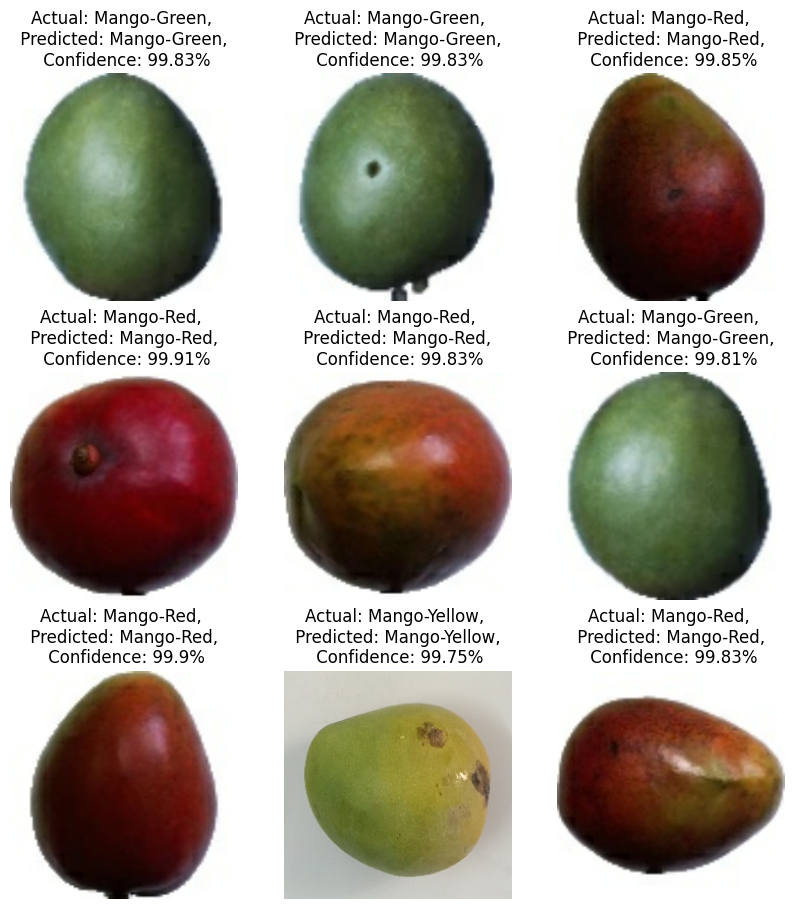

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(10, 11))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

# Model Evualuation

In [27]:
scores = resnet_model.evaluate(test_ds) # No Fine-Tuning

5/5 [==============================] - 1s 92ms/step - loss: 0.0851 - accuracy: 1.0000


In [28]:
# code to view f1 score and other metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

5/5 [==============================] - 0s 72ms/step
F1 Score: 0.675
Precision: 0.675
Recall: 0.675
Accuracy: 0.675
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        72
           1       0.66      0.66      0.66        64
           2       0.58      0.58      0.58        24

    accuracy                           0.68       160
   macro avg       0.65      0.65      0.65       160
weighted avg       0.68      0.68      0.68       160



5/5 [==============================] - 0s 72ms/step


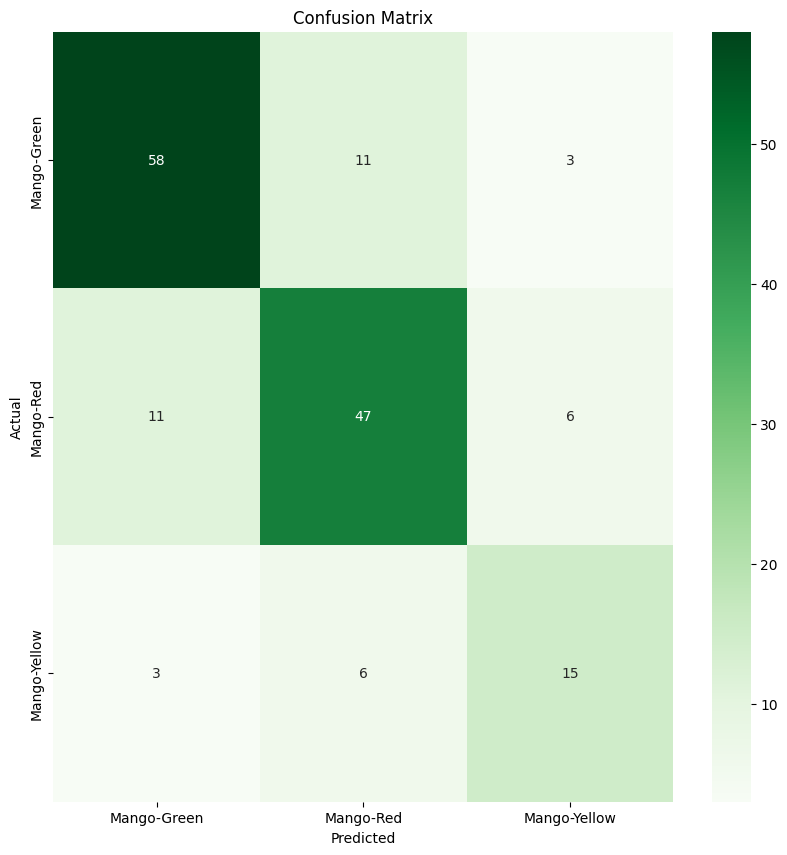

In [29]:
#code block to show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting History | No Fine-Tuning

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

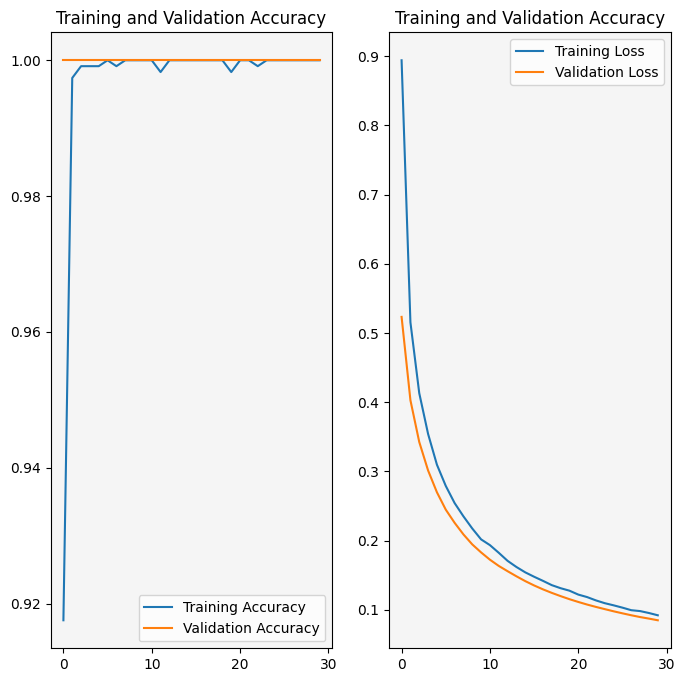

In [31]:
completed_epochs = len(history.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs), acc, label='Training Accuracy')
plt.plot(range(completed_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs), loss, label='Training Loss')
plt.plot(range(completed_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.show()

# Saving Model (NOT FINE TUNED)

In [ ]:
os.makedirs("../modelsNFT", exist_ok=True) #If modelsNFT directory doesn't exist yet

In [39]:
model_version = max([int(i) for i in os.listdir("../modelsNFT") + [0]]) + 1
resnet_model.save(f"../modelsNFT/{model_version}")

INFO:tensorflow:Assets written to: ../modelsNFT/2\assets


INFO:tensorflow:Assets written to: ../modelsNFT/2\assets


# Fine Tuning
## Un-Freeze and Fine-tune the model

In [41]:
base_model = resnet_model.layers[0]

In [42]:
# Unfreeze only a subset of layers

# Freeze all layers except the last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Unfreeze the last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

resnet_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                131136    
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                      

Continue training the entire model

In [43]:
history_finetune = resnet_model.fit(
    train_ds,
    epochs=10,  # Additional epochs for fine-tuning
    batch_size = 64,
    validation_data=val_ds,
)

Epoch 1/10
36/36 [==============================] - 6s 101ms/step - loss: 0.1369 - accuracy: 0.9861 - val_loss: 11.1730 - val_accuracy: 0.1484
Epoch 2/10
36/36 [==============================] - 3s 80ms/step - loss: 0.0762 - accuracy: 0.9983 - val_loss: 1.9478 - val_accuracy: 0.5000
Epoch 3/10
36/36 [==============================] - 3s 80ms/step - loss: 0.0545 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 1.0000
Epoch 4/10
36/36 [==============================] - 3s 80ms/step - loss: 0.0438 - accuracy: 0.9991 - val_loss: 0.0336 - val_accuracy: 1.0000
Epoch 5/10
36/36 [==============================] - 3s 81ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.0253 - val_accuracy: 1.0000
Epoch 6/10
36/36 [==============================] - 3s 82ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 7/10
36/36 [==============================] - 3s 83ms/step - loss: 0.0221 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 8/10


In [44]:
#show highest accuracy and validation accuracy show lowest loss and validation loss and latest of each
print("Highest Accuracy: ", max(history_finetune.history['accuracy']))
print("Highest Validation Accuracy: ", max(history_finetune.history['val_accuracy']))
print("Lowest Loss: ", min(history_finetune.history['loss']))
print("Lowest Validation Loss: ", min(history_finetune.history['val_loss']))
print("Final Accuracy: ", history_finetune.history['accuracy'][-1])
print("Final Validation Accuracy: ", history_finetune.history['val_accuracy'][-1])
print("Final Loss: ", history_finetune.history['loss'][-1])
print("Final Validation Loss: ", history_finetune.history['val_loss'][-1])

Highest Accuracy:  1.0
Highest Validation Accuracy:  1.0
Lowest Loss:  0.014759797602891922
Lowest Validation Loss:  0.011702767573297024
Final Accuracy:  1.0
Final Validation Accuracy:  1.0
Final Loss:  0.015329334884881973
Final Validation Loss:  0.017152385786175728


In [45]:
# code to view f1 score and other metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# code to view f1 score and other metrics
y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

5/5 [==============================] - 1s 58ms/step
F1 Score: 0.63125
Precision: 0.63125
Recall: 0.63125
Accuracy: 0.63125
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        72
           1       0.59      0.59      0.59        64
           2       0.46      0.46      0.46        24

    accuracy                           0.63       160
   macro avg       0.59      0.59      0.59       160
weighted avg       0.63      0.63      0.63       160



In [46]:
scores = resnet_model.evaluate(test_ds) # With Fine Tuning

5/5 [==============================] - 0s 60ms/step - loss: 0.0167 - accuracy: 1.0000


# Plotting History | With Fine-Tuning

In [47]:
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']

loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

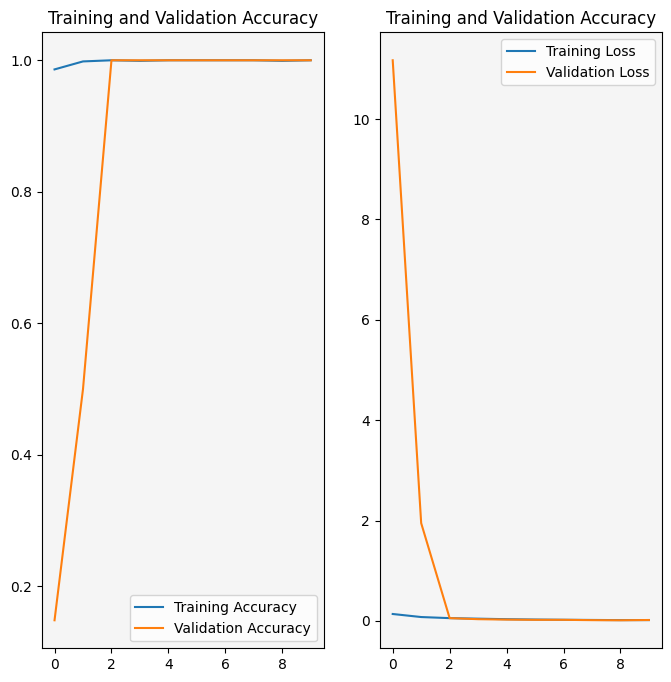

In [ ]:
#Determine the number of epochs completed during fine-tuning by checking the length of the accuracy history
completed_epochs2 = len(history_finetune.history['accuracy'])

plt.figure(figsize=(8, 8))# Set the overall figure size for the plotsa
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs2), acc, label='Training Accuracy')
plt.plot(range(completed_epochs2), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs2), loss, label='Training Loss')
plt.plot(range(completed_epochs2), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.show()

# Making a Prediction (Fine Tuned)

1/1 [==============================] - 0s 20ms/step


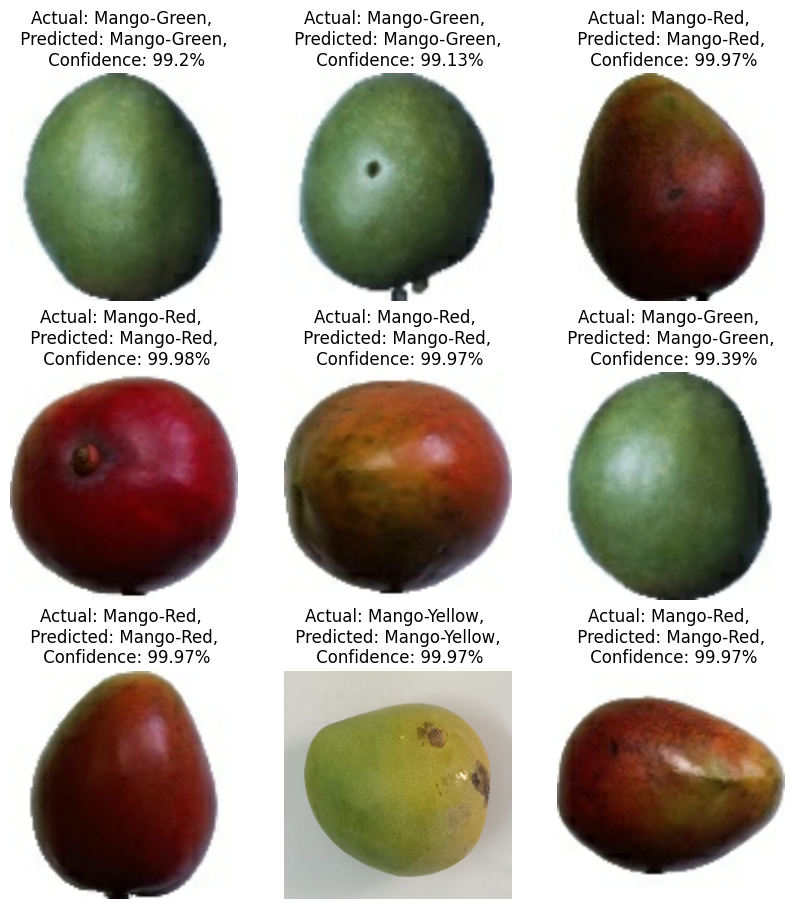

In [ ]:
def predict(model, img):
    # Convert the image to an array and create a batch dimension
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Expand dimensions so that the image tensor has a batch dimension (required ng model.predict).
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(10, 11))

for images, labels in test_ds.take(1):
    for i in range(9): # Loops the images 9 in the batch.
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")


Confusion Matrix

5/5 [==============================] - 1s 151ms/step


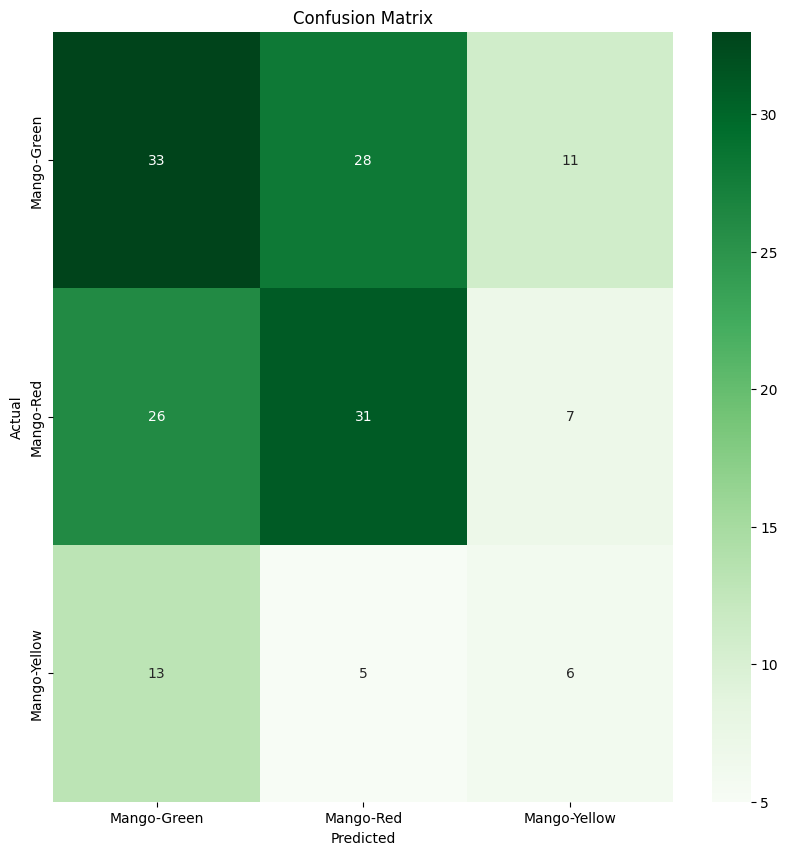

In [52]:
#code block to show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Saving Model (FINE TUNED)

In [54]:
os.makedirs("../modelsFT", exist_ok=True) #If modelsFT directory doesn't exist yet

In [55]:
model_version = max([int(i) for i in os.listdir("../modelsFT") + [0]]) + 1
resnet_model.save(f"../modelsFT/{model_version}")

INFO:tensorflow:Assets written to: ../modelsFT/1\assets


INFO:tensorflow:Assets written to: ../modelsFT/1\assets


1/1 [==============================] - 0s 22ms/step


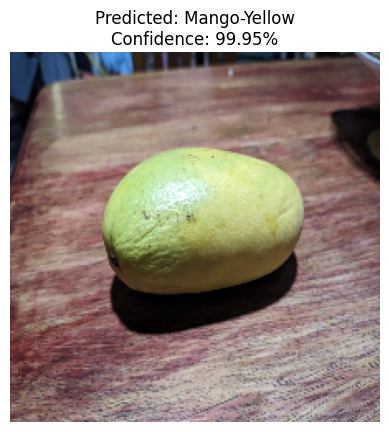

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Set the image dimensions to match your model input
IMG_HEIGHT, IMG_WIDTH = 224, 224  # update these as needed
new_image_path = "Test/Mango-1.jpg"  # specify the path to your image

# Load and preprocess the image
img = image.load_img(new_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # create a batch

# Performing the prediction
predictions = resnet_model.predict(img_array)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * np.max(predictions[0]), 2)

# Display the picture with the details
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
plt.axis('off')
plt.show()
